## Computational Reactor Physics with Python - Shannon Entropy

Author: OdinhengeT

Date: 2022-08-31

This is the first jupyter notebook ('calculations.ipynb'), where the Monte Carlo calculations are preformed and the data is stored as files in /results. In the second notebook ('analysis.ipynb'), this data is then examined. The goal of these notebooks is to look at the convergence of the Shannon entropy and how it is influenced by factors such as geometry, coarseness of entropy mesh and number of neutrons per batch.

---

### Setup

In [1]:
# Imports
import os
import math
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Materials

# Remove previous materials file
os.system('rm -f materials.xml');
# Fuel
uraniumdioxide = openmc.Material(1, "uranium-dioxide", temperature=1200)
uraniumdioxide.add_nuclide('U235', 0.04)
uraniumdioxide.add_nuclide('U238', 0.96)
uraniumdioxide.add_nuclide('O16', 2.0)
uraniumdioxide.set_density('g/cm3', 10.5)

# Cladding
zirconium = openmc.Material(2, "zirconium", temperature=900)
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

# Moderator
water = openmc.Material(3, "water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.75) 
# This is at high pressure and temperature so the regular ~1 g/cm3 doesn't hold
# https://www.researchgate.net/figure/Water-density-as-a-function-of-temperature-and-pressure_fig3_257989805 
water.add_s_alpha_beta('c_H_in_H2O')

# Boiler wall - Taken to be made of some kind of steel (or wrought iron) with mainly iron and coal in the chemical makeup.
# Values come from different wikipedia sites.
steel = openmc.Material(4, "wrough-iron", )
steel.add_element('Fe', 99.75, percent_type='wo')
steel.add_element('C', 0.25, percent_type='wo')
steel.set_density('g/cm3', 7.8)

materials = openmc.Materials([uraniumdioxide, zirconium, water, steel])
materials.export_to_xml()

In [7]:
# Geometry
def create_geometry(geometry_id, boiler_radius_outer, boiler_thickness, fuel_pin_radius, pitch, plot_geometry=False):
    # Remove previous geometry file
    os.system('rm -f geometry.xml');
    
    boiler_radius_inner = boiler_radius_outer - boiler_thickness
    
    # Bounds (1/4 Cylinder)
    bound_x = openmc.XPlane(x0=0, boundary_type='reflective')
    bound_y = openmc.YPlane(y0=0, boundary_type='reflective')
    bound_cyl = openmc.ZCylinder(x0=0, y0=0, r=boiler_radius_outer, boundary_type='vacuum')

    # Boiler wall
    boilerWall_cyl_inner = openmc.ZCylinder(x0=0, y0=0, r=boiler_radius_inner)
    boilerWall_region = +boilerWall_cyl_inner & -bound_cyl & +bound_x & +bound_y 

    # Fuel rods with cladding & surrounding water

    fuel_cyl = openmc.ZCylinder(x0=0, y0=0, r=fuel_pin_radius-0.04)       
    clad_cyl_inner = openmc.ZCylinder(x0=0, y0=0, r=fuel_pin_radius-0.03) 
    clad_cyl_outer = openmc.ZCylinder(x0=0, y0=0, r=fuel_pin_radius)
    fuel_region = -fuel_cyl & +bound_x & +bound_y 
    gap_region = +fuel_cyl & -clad_cyl_inner & +bound_x & +bound_y 
    clad_region = +clad_cyl_inner & -clad_cyl_outer & +bound_x & +bound_y 
    water_region = -boilerWall_cyl_inner & +bound_x & +bound_y & +clad_cyl_outer

    for x in range(int((boiler_radius_inner-10)/pitch)):
        for y in range(int((boiler_radius_inner-10)/pitch)):
            if 0.0 < x**2 + y**2 < ((boiler_radius_inner-10)/pitch)**2:
                fuel_cyl = openmc.ZCylinder(x0=pitch*x, y0=pitch*y, r=0.41)
                clad_cyl_inner = openmc.ZCylinder(x0=pitch*x, y0=pitch*y, r=0.42)
                clad_cyl_outer = openmc.ZCylinder(x0=pitch*x, y0=pitch*y, r=0.45)
                fuel_region = fuel_region | (-fuel_cyl & +bound_x & +bound_y)
                gap_region = gap_region | (+fuel_cyl & -clad_cyl_inner & +bound_x & +bound_y)
                clad_region = clad_region | (+clad_cyl_inner & -clad_cyl_outer & +bound_x & +bound_y)
                water_region = water_region & +clad_cyl_outer

    # Cells 
    boilerWall = openmc.Cell(name='boiler-wall')
    boilerWall.region = boilerWall_region
    boilerWall.fill = steel

    fuel = openmc.Cell(name='fuel')
    fuel.region = fuel_region
    fuel.fill = uraniumdioxide

    gap = openmc.Cell(name='air gap')
    gap.region = gap_region
    # We neglect the effect of the gas in this gap region

    cladding = openmc.Cell(name='cladding')
    cladding.region = clad_region
    cladding.fill = zirconium

    moderator = openmc.Cell(name='moderator')
    moderator.region = water_region
    moderator.fill = water

    geometry = openmc.Geometry()
    geometry.root_universe = openmc.Universe(cells=(boilerWall, fuel, gap, cladding, moderator))
    geometry.export_to_xml()

    # Plots
    if plot_geometry:
        # Remove previous plots
        os.system('rm -f plots.xml');
        os.system('mkdir -p plots')
        
        # Entire geometry
        plot = openmc.Plot()
        plot.origin = (boiler_radius_outer/2, boiler_radius_outer/2, 0)
        plot.width = (boiler_radius_outer, boiler_radius_outer)
        plot.pixels = (1400, 1400)
        plot.filename = 'plots/geometry_'+str(geometry_id)+' overview'
        openmc.plot_inline(plot)

        # Zoom in on fuel rods
        plot = openmc.Plot()
        plot.origin=(5*pitch, 5*pitch, 0)
        plot.width=(4*pitch, pitch)
        plot.pixels = (1400, 350)
        plot.filename = 'plots/geometry_'+str(geometry_id)+' zoom'
        openmc.plot_inline(plot)
    return geometry

In [10]:
# Settings 
def create_settings(nBatches, nParticles, mesh_size, geometry_id):
    # Remove previous settings file
    os.system('rm -f settings.xml');

    settings = openmc.Settings()

    # Mesh for calculation of Shannon entropy 
    entropy_mesh = openmc.RegularMesh()
    entropy_mesh.lower_left, entropy_mesh.upper_right = geometry.bounding_box
    entropy_mesh.dimension = (mesh_size, mesh_size)
    settings.entropy_mesh = entropy_mesh

    # Source point 
    src = openmc.Source(space=openmc.stats.Point((16, 16, 0)))
    settings.source = src

    # Neutron generations
    settings.batches = nBatches
    settings.inactive = 0
    settings.particles = nParticles

    # Tallies
    path = 'results/geometry_'+str(geometry_id)+'/batch'+str(nBatches)+'_particles'+str(nParticles)+'_mesh'+str(mesh_size)+'/'
    os.system('mkdir -p '+path)
    settings.output = {'tallies': False, 'path': path}
    settings.export_to_xml()
    return settings

### Calculations for Geometry 1

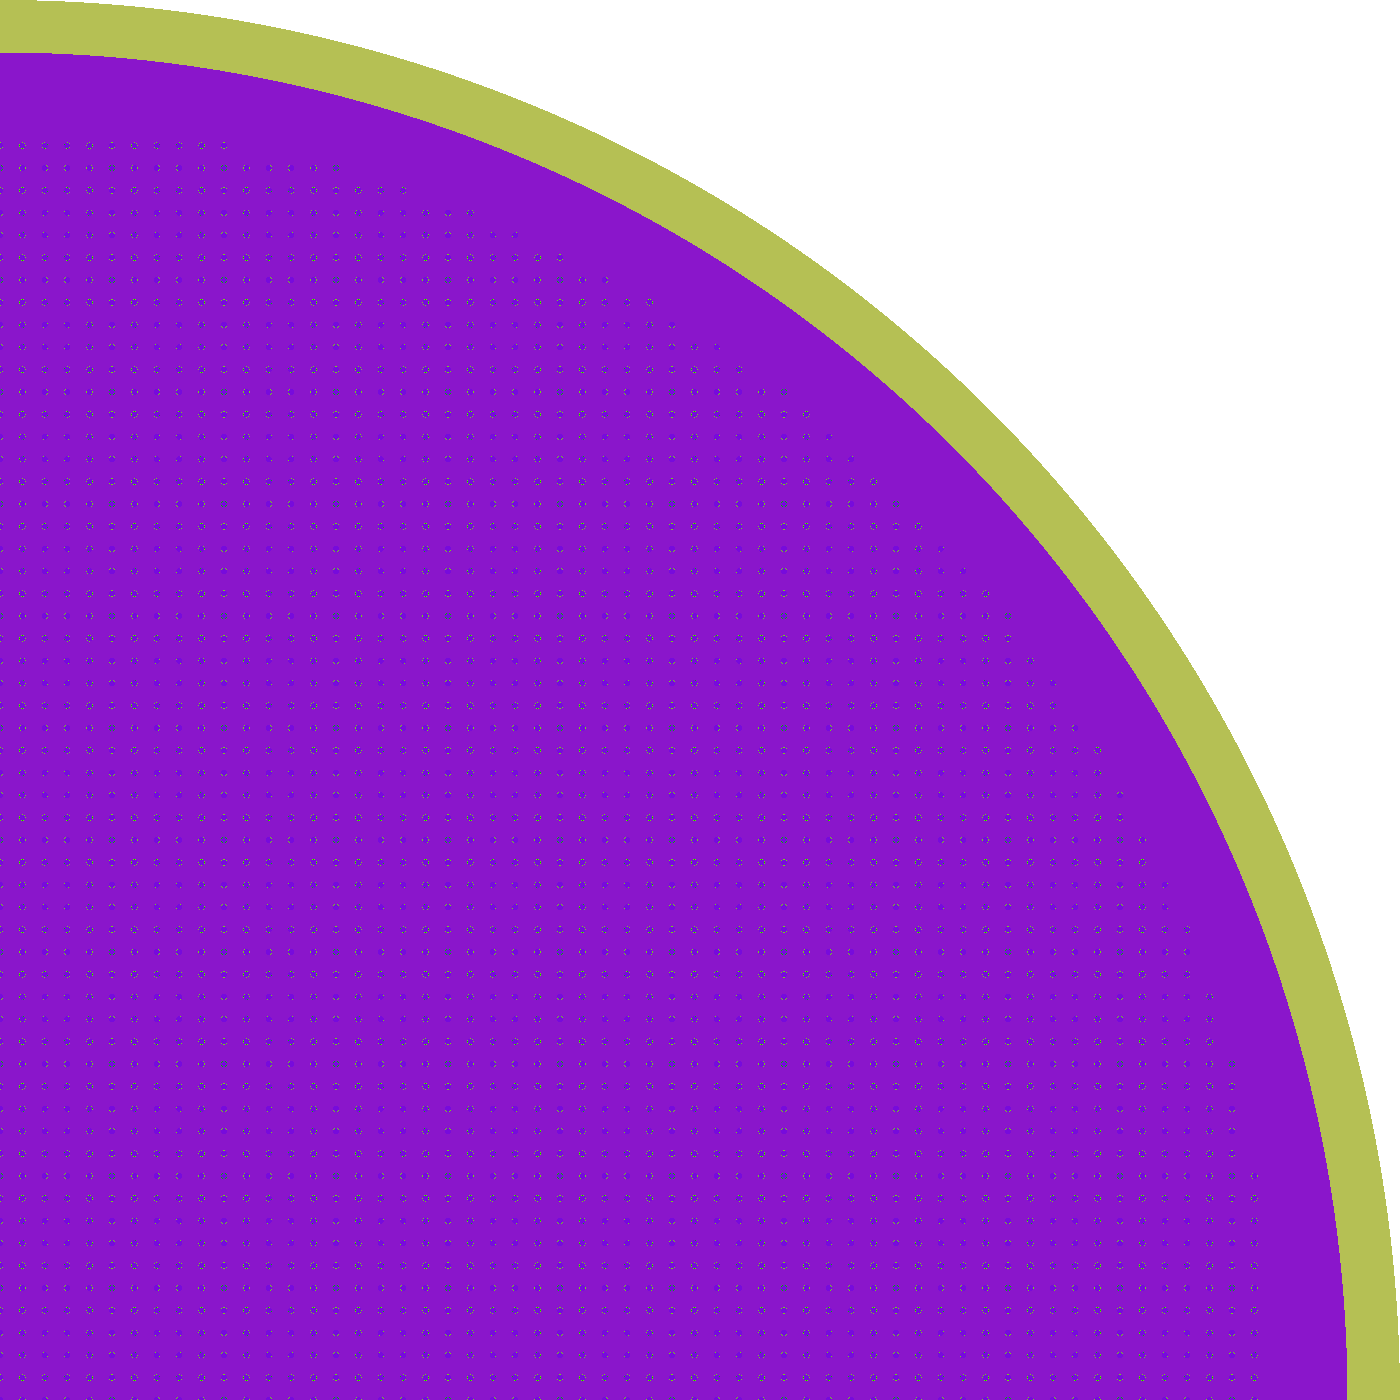

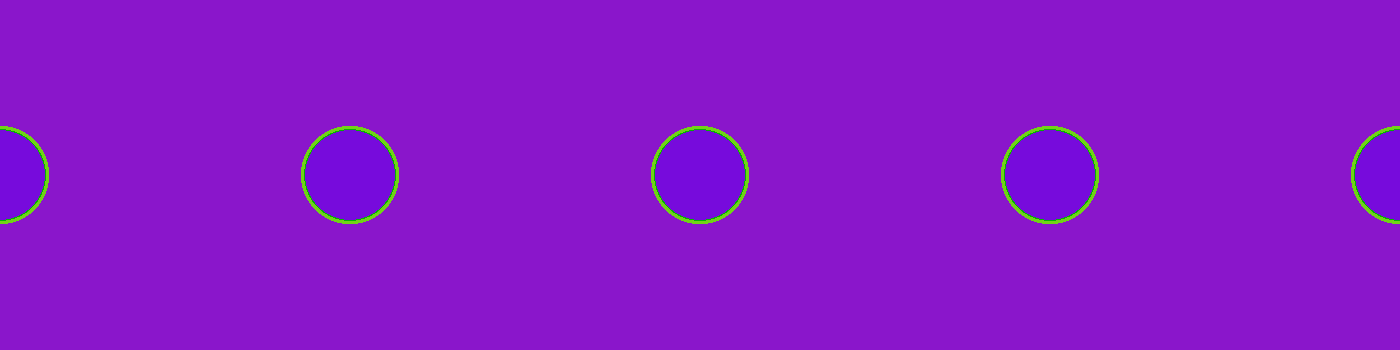

In [5]:
# Generate geometry 1
 
geometry = create_geometry(
    geometry_id = 1,
    boiler_radius_outer = 200, 
    boiler_thickness = 7.5, 
    fuel_pin_radius = 0.5,
    pitch = 3.2,
    plot_geometry = True
)

In [13]:
# Run calculations for geometry 1

k_effs = {}
entropies = {}

nBatches = 250
particle_nbrs = [5000]
mesh_sizes = [16, 32]

for nParticles in particle_nbrs:
    
    for mesh_size in mesh_sizes:

        settings = create_settings(nBatches=nBatches, nParticles=nParticles, mesh_size=mesh_size, geometry_id=1)

        # Model
        model = openmc.model.Model(geometry, materials, settings)
        model.run(output=False)

### Calculations for Geometry 2

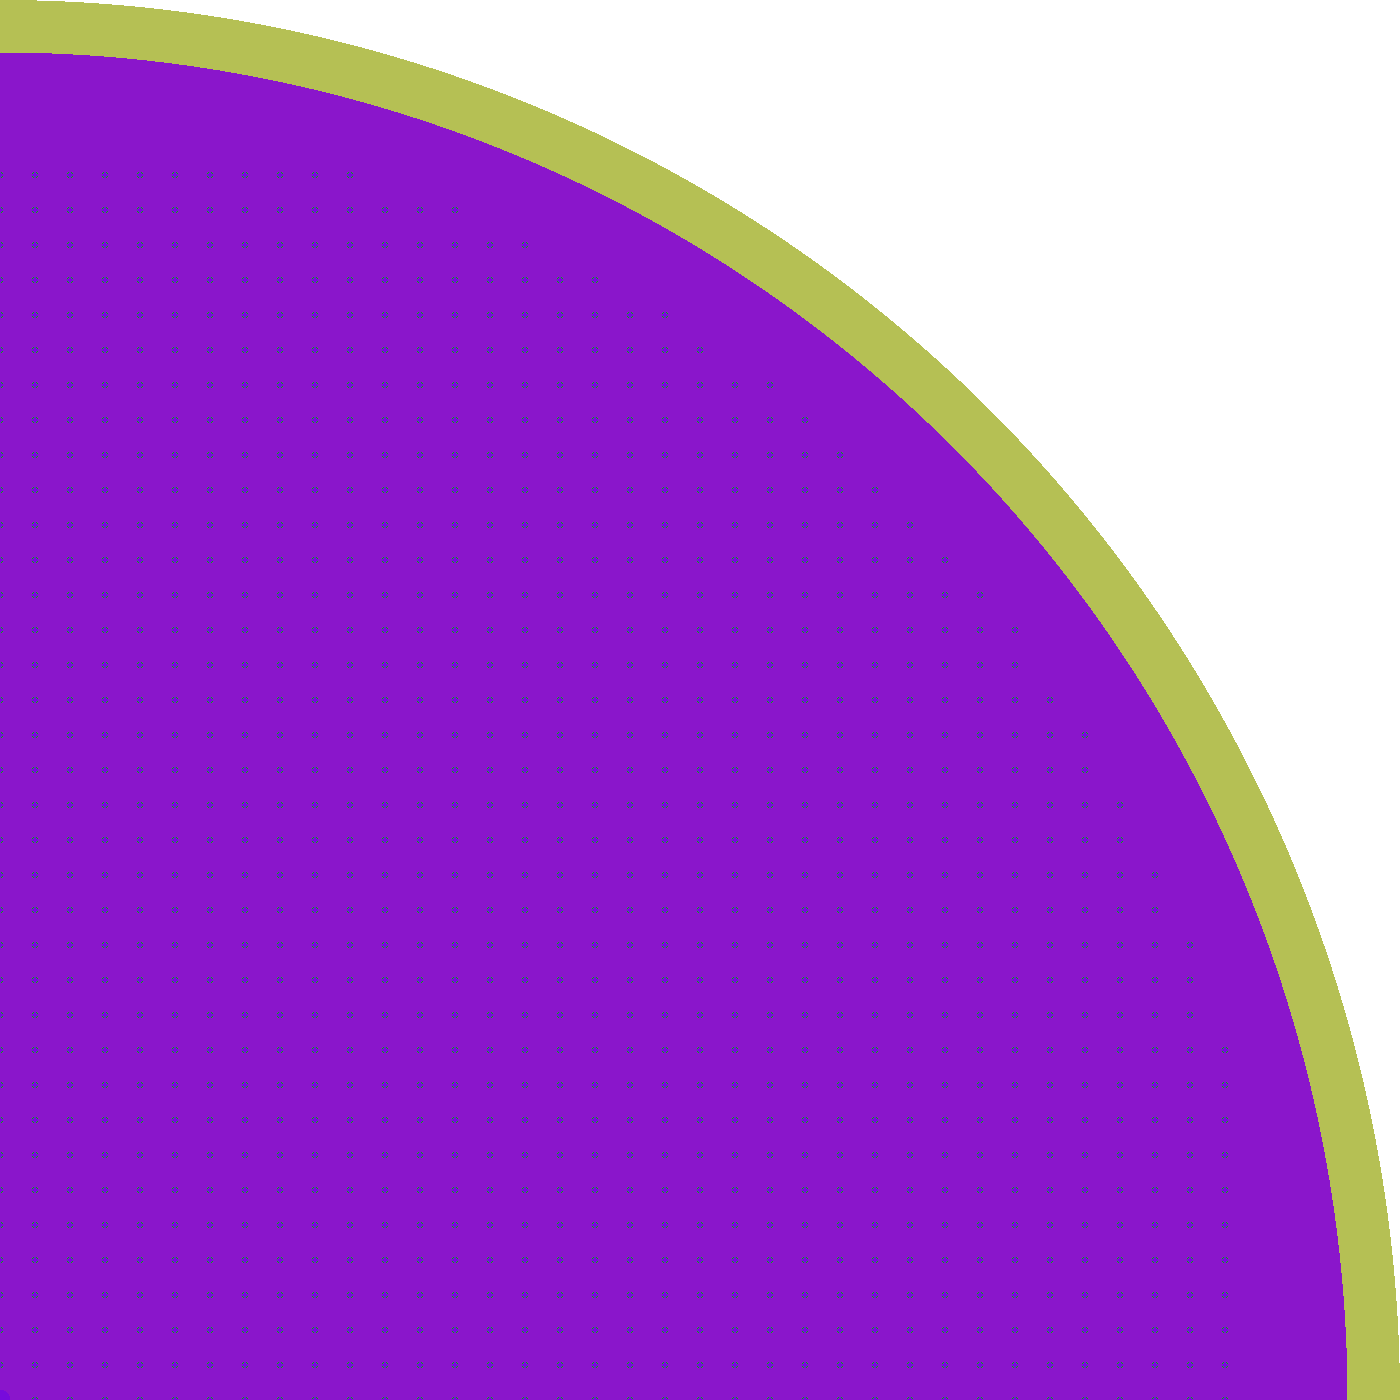

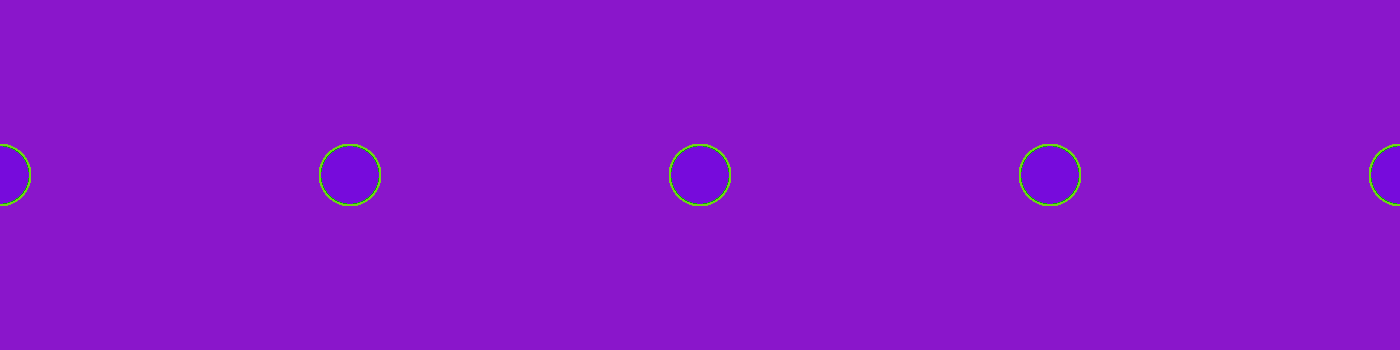

In [14]:
# Generate geometry 2

geometry = create_geometry(
    geometry_id = 2,
    boiler_radius_outer = 200, 
    boiler_thickness = 7.5, 
    fuel_pin_radius = 1.5,
    pitch = 5,
    plot_geometry = True
)

In [15]:
# Run calculations for geometry 2

nBatches = 250
particle_nbrs = [5000]
mesh_sizes = [4, 8, 16, 32]

for nParticles in particle_nbrs:
    
    for mesh_size in mesh_sizes:

        settings = create_settings(nBatches=nBatches, nParticles=nParticles, mesh_size=mesh_size, geometry_id=2)

        # Model
        model = openmc.model.Model(geometry, materials, settings)
        model.run(output=False)

### End of Notebook 1